In [2]:
!pip install torchvision timm -q

In [3]:
import os
import random
import time

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# ===== 하이퍼파라미터 & 경로 설정 =====
batch_size = 16
num_epochs = 20
lr = 1e-4
image_size = 224
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 42

print("Device:", device)

DATA_ROOT = "/content/chest_xray/chest_xray"
train_dir = os.path.join(DATA_ROOT, "train")
val_dir   = os.path.join(DATA_ROOT, "val")
test_dir  = os.path.join(DATA_ROOT, "test")
print(train_dir, val_dir, test_dir)


Device: cuda
/content/chest_xray/chest_xray/train /content/chest_xray/chest_xray/val /content/chest_xray/chest_xray/test


In [6]:
# ===== 시드 고정 =====
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)


In [7]:
# ===== 데이터 변환(전처리 + 증강) 정의 =====
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import zipfile, os

zip_path = "/content/drive/MyDrive/archive.zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content/chest_xray")

!ls /content
!ls /content/chest_xray


chest_xray  drive  sample_data
chest_xray


In [10]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=val_test_transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=val_test_transform)

class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['NORMAL', 'PNEUMONIA']


In [11]:
# ===== DataLoader 정의 =====
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True)


In [13]:
# ===== EfficientNet-B0 불러오기 (torchvision) =====
base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

in_features = base_model.classifier[1].in_features
base_model.classifier[1] = nn.Linear(in_features, 1)

model = base_model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")


Total parameters: 4,008,829


In [14]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)


In [15]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_logits = []

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        all_labels.append(labels.detach().cpu().numpy())
        all_logits.append(logits.detach().cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_logits = np.vstack(all_logits)

    probs = torch.sigmoid(torch.tensor(all_logits)).numpy()
    preds = (probs > 0.5).astype(int)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, preds)
    try:
        epoch_auc = roc_auc_score(all_labels, probs)
    except:
        epoch_auc = float("nan")

    return epoch_loss, epoch_acc, epoch_auc


def eval_one_epoch(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_logits = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Eval", leave=False):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            logits = model(images)
            loss = loss_fn(logits, labels)

            running_loss += loss.item() * images.size(0)
            all_labels.append(labels.detach().cpu().numpy())
            all_logits.append(logits.detach().cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_logits = np.vstack(all_logits)

    probs = torch.sigmoid(torch.tensor(all_logits)).numpy()
    preds = (probs > 0.5).astype(int)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, preds)
    try:
        epoch_auc = roc_auc_score(all_labels, probs)
    except:
        epoch_auc = float("nan")

    return epoch_loss, epoch_acc, epoch_auc, all_labels, preds, probs


In [16]:
best_val_auc = -1
best_state_dict = None

train_history = {"loss": [], "acc": [], "auc": []}
val_history   = {"loss": [], "acc": [], "auc": []}

for epoch in range(1, num_epochs+1):
    print(f"\n===== Epoch {epoch}/{num_epochs} =====")
    start_time = time.time()

    train_loss, train_acc, train_auc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc, val_auc, _, _, _ = eval_one_epoch(model, val_loader, loss_fn, device)

    train_history["loss"].append(train_loss)
    train_history["acc"].append(train_acc)
    train_history["auc"].append(train_auc)

    val_history["loss"].append(val_loss)
    val_history["acc"].append(val_acc)
    val_history["auc"].append(val_auc)

    elapsed = time.time() - start_time

    print(f"Train  - loss: {train_loss:.4f}, acc: {train_acc:.4f}, auc: {train_auc:.4f}")
    print(f"Val    - loss: {val_loss:.4f}, acc: {val_acc:.4f}, auc: {val_auc:.4f}")
    print(f"Epoch time: {elapsed/60:.1f} min")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_state_dict = model.state_dict()
        print(">> Best model updated.")



===== Epoch 1/20 =====


Train  - loss: 0.1832, acc: 0.9365, auc: 0.9792
Val    - loss: 0.2406, acc: 0.9375, auc: 1.0000
Epoch time: 1.7 min
>> Best model updated.

===== Epoch 2/20 =====


Train  - loss: 0.0737, acc: 0.9758, auc: 0.9954
Val    - loss: 0.0391, acc: 1.0000, auc: 1.0000
Epoch time: 1.6 min

===== Epoch 3/20 =====


Train  - loss: 0.0498, acc: 0.9824, auc: 0.9980
Val    - loss: 0.0996, acc: 1.0000, auc: 1.0000
Epoch time: 1.5 min

===== Epoch 4/20 =====


Train  - loss: 0.0411, acc: 0.9864, auc: 0.9985
Val    - loss: 0.4592, acc: 0.8125, auc: 1.0000
Epoch time: 1.5 min

===== Epoch 5/20 =====


Train  - loss: 0.0375, acc: 0.9891, auc: 0.9985
Val    - loss: 0.2793, acc: 0.7500, auc: 1.0000
Epoch time: 1.6 min

===== Epoch 6/20 =====


Train  - loss: 0.0285, acc: 0.9904, auc: 0.9994
Val    - loss: 0.1416, acc: 0.9375, auc: 1.0000
Epoch time: 1.5 min

===== Epoch 7/20 =====


Train  - loss: 0.0238, acc: 0.9919, auc: 0.9995
Val    - loss: 0.2057, acc: 0.8125, auc: 1.0000
Epoch time: 1.6 min

===== Epoch 8/20 =====


Train  - loss: 0.0188, acc: 0.9929, auc: 0.9997
Val    - loss: 0.4939, acc: 0.7500, auc: 1.0000
Epoch time: 1.5 min

===== Epoch 9/20 =====


Train  - loss: 0.0142, acc: 0.9960, auc: 0.9998
Val    - loss: 0.0305, acc: 1.0000, auc: 1.0000
Epoch time: 1.5 min

===== Epoch 10/20 =====


Train  - loss: 0.0207, acc: 0.9918, auc: 0.9996
Val    - loss: 1.1621, acc: 0.7500, auc: 1.0000
Epoch time: 1.6 min

===== Epoch 11/20 =====


Train  - loss: 0.0159, acc: 0.9946, auc: 0.9997
Val    - loss: 0.0135, acc: 1.0000, auc: 1.0000
Epoch time: 1.5 min

===== Epoch 12/20 =====


Train  - loss: 0.0121, acc: 0.9954, auc: 0.9999
Val    - loss: 0.0724, acc: 0.9375, auc: 1.0000
Epoch time: 1.5 min

===== Epoch 13/20 =====


Train  - loss: 0.0111, acc: 0.9967, auc: 0.9999
Val    - loss: 0.1871, acc: 0.8750, auc: 1.0000
Epoch time: 1.5 min

===== Epoch 14/20 =====


Train  - loss: 0.0081, acc: 0.9965, auc: 1.0000
Val    - loss: 0.0490, acc: 1.0000, auc: 1.0000
Epoch time: 1.5 min

===== Epoch 15/20 =====


Train  - loss: 0.0098, acc: 0.9971, auc: 0.9998
Val    - loss: 0.0780, acc: 0.9375, auc: 1.0000
Epoch time: 1.5 min

===== Epoch 16/20 =====


Train  - loss: 0.0113, acc: 0.9965, auc: 0.9998
Val    - loss: 0.4885, acc: 0.7500, auc: 1.0000
Epoch time: 1.5 min

===== Epoch 17/20 =====


Train  - loss: 0.0105, acc: 0.9965, auc: 0.9998
Val    - loss: 0.0560, acc: 1.0000, auc: 1.0000
Epoch time: 1.5 min

===== Epoch 18/20 =====


Train  - loss: 0.0140, acc: 0.9942, auc: 0.9998
Val    - loss: 0.2859, acc: 0.9375, auc: 1.0000
Epoch time: 1.5 min

===== Epoch 19/20 =====


Train  - loss: 0.0086, acc: 0.9967, auc: 0.9999
Val    - loss: 0.0194, acc: 1.0000, auc: 1.0000
Epoch time: 1.6 min

===== Epoch 20/20 =====


Train  - loss: 0.0083, acc: 0.9975, auc: 0.9999
Val    - loss: 0.8225, acc: 0.8125, auc: 1.0000
Epoch time: 1.5 min


In [17]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=49a924f5a4cff495780f7933d55299dce9103db14f3ad71ecbb172fc1afbcbcf
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [18]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]


In [19]:
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)


NORMAL example index : 0
PNEUMONIA example index : 234


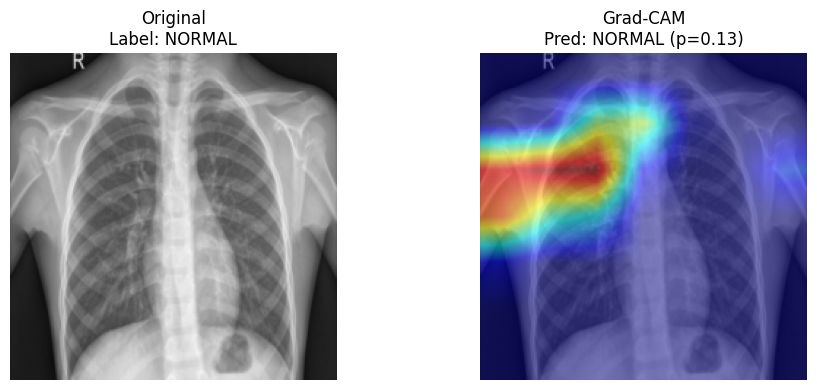

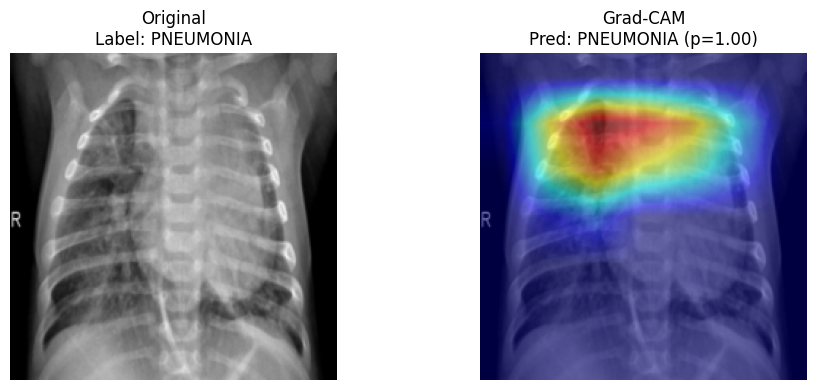

In [20]:
# === Grad-CAM 시각화 ===

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms


target_layers = [model.features[-1][0]]
eff_cam = GradCAM(
    model=model,
    target_layers=target_layers
)
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)

def visualize_efficientnet_cam(dataset, index):
    model.eval()

    img, label = dataset[index]
    input_tensor = img.unsqueeze(0).to(device)

    img_vis = inv_normalize(img).permute(1, 2, 0).cpu().numpy()
    img_vis = np.clip(img_vis, 0, 1)
    if img_vis.shape[2] == 1:
        img_vis = np.repeat(img_vis, 3, axis=2)

    grayscale_cam = eff_cam(input_tensor=input_tensor)[0]  # (H,W)
    cam_image = show_cam_on_image(img_vis, grayscale_cam, use_rgb=True)

    with torch.no_grad():
        logit = model(input_tensor)
        prob = torch.sigmoid(logit)[0].item()
        pred = int(prob > 0.5)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img_vis)
    plt.axis("off")
    plt.title(f"Original\nLabel: {class_names[label]}")

    plt.subplot(1, 2, 2)
    plt.imshow(cam_image)
    plt.axis("off")
    plt.title(f"Grad-CAM\nPred: {class_names[pred]} (p={prob:.2f})")

    plt.tight_layout()
    plt.show()

targets = test_dataset.targets
idx_normal = next(i for i, t in enumerate(targets) if t == 0)
idx_pneu   = next(i for i, t in enumerate(targets) if t == 1)

print("NORMAL example index :", idx_normal)
print("PNEUMONIA example index :", idx_pneu)

visualize_efficientnet_cam(test_dataset, idx_normal)
visualize_efficientnet_cam(test_dataset, idx_pneu)



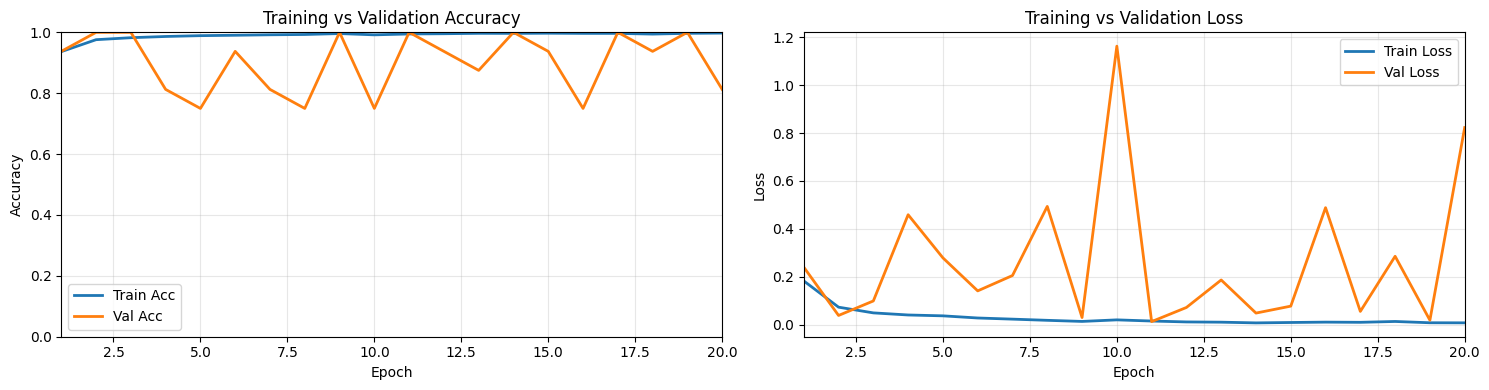

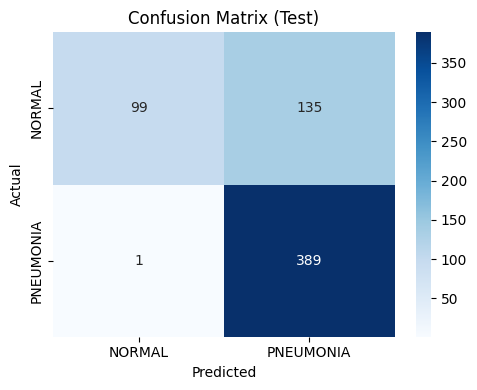

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# 0. Test 전체 예측 (y_true, y_probs, y_pred 구하기)
model.eval()
all_labels = []
all_logits = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        logits = model(images)

        all_labels.append(labels.cpu().numpy())
        all_logits.append(logits.cpu().numpy())

y_true = np.vstack(all_labels)
logits = np.vstack(all_logits)

y_probs = torch.sigmoid(torch.tensor(logits)).numpy().reshape(-1)
y_true  = y_true.reshape(-1)
y_pred  = (y_probs > 0.5).astype(int)

class_names = ["NORMAL", "PNEUMONIA"]

# 1. 학습 곡선: Accuracy
epochs = range(1, len(train_history["acc"]) + 1)

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_history["acc"], label="Train Acc", linewidth=2)
plt.plot(epochs, val_history["acc"],   label="Val Acc",   linewidth=2)
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(1, len(train_history["acc"]))
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend()

# 2. 학습 곡선: Loss
plt.subplot(1,2,2)
plt.plot(epochs, train_history["loss"], label="Train Loss", linewidth=2)
plt.plot(epochs, val_history["loss"],   label="Val Loss",   linewidth=2)
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(1, len(train_history["loss"]))
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# 3. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()
